In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import classification_report, accuracy_score

In [121]:
file = pd.read_csv('DOGE-USD.csv')
temp = copy.deepcopy(file)

In [122]:
# replacing the null values by taking mean of previous value and after values of the respective column
for i in range(len(file)):
  temp_val = file.iloc[i].values
  for j in range(len(temp_val)):
    if pd.isna(temp_val[j]):
      if i != 0 and i != len(file) - 1:
        prev_val = file.iloc[i - 1, j]
        after_val = file.iloc[i + 1, j]
      elif i == 0:
        prev_val = np.nan
        after_val = file.iloc[i + 1, j]
      else:
        prev_val = file.iloc[i - 1, j]
        after_val = np.nan

      if pd.isna(prev_val):
        new_value = after_val
      elif pd.isna(after_val):
        new_value = prev_val
      else:
        new_value = (prev_val / after_val) / 2

      file.iloc[i, j] = new_value

In [123]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2335 non-null   object 
 1   Open       2335 non-null   float64
 2   High       2335 non-null   float64
 3   Low        2335 non-null   float64
 4   Close      2335 non-null   float64
 5   Adj Close  2335 non-null   float64
 6   Volume     2335 non-null   float64
dtypes: float64(6), object(1)
memory usage: 127.8+ KB


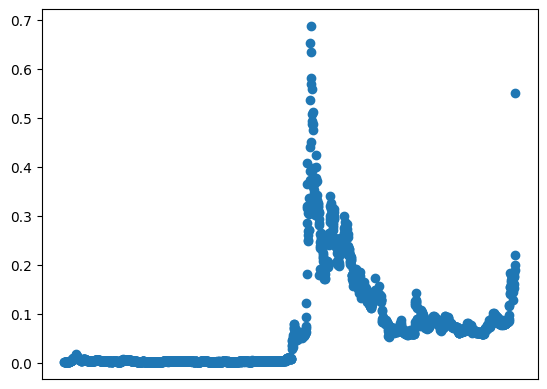

In [124]:
plt.scatter(file['Date'], file['Open'])
plt.xticks([])
plt.show()

In [125]:
file['SMA'] = file['Close'].rolling(3).mean()


In [126]:
file['SMA'] = file['SMA'].replace(np.nan, 0)

In [127]:
file.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0,0.000000
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0,0.000000
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0,0.001260
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0,0.001134
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0,0.001150


In [128]:
file['Future Close'] = 0
for i in range(len(file)):
  pos = 7
  if i == len(file) - 1:
    file.iloc[i, pos] = file.iloc[len(file) - 1, 2]
  else:
    file.iloc[i, pos + 1] = file.iloc[i + 1 , 7]
file['Date'] = pd.to_datetime(file['Date'])
file['Date'] = file['Date'].map(pd.Timestamp.timestamp)

In [129]:
file= file[['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'SMA', 'Close', 'Future Close']]
file.dropna()
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2335 non-null   float64
 1   Open          2335 non-null   float64
 2   High          2335 non-null   float64
 3   Low           2335 non-null   float64
 4   Adj Close     2335 non-null   float64
 5   Volume        2335 non-null   float64
 6   SMA           2335 non-null   float64
 7   Close         2335 non-null   float64
 8   Future Close  2335 non-null   float64
dtypes: float64(9)
memory usage: 164.3 KB


In [130]:
x_close = file['Close']
x_close.columns = ["Close Price"]
x_close.shape


(2335,)

In [131]:
x_train = x_close[0:x_close.shape[0] // 2]
x_test = x_close[1167:]
x_test.index = [i for i in range(2335 - 1167)]

In [132]:
sequence = TimeseriesGenerator(x_train, x_train, length = 12, batch_size = 1)


In [133]:
x,y = sequence[1]
x, y

(array([[0.001163, 0.001201, 0.001038, 0.001211, 0.001184, 0.001339,
         0.00139 , 0.001313, 0.001373, 0.001376, 0.001394, 0.001389]]),
 array([0.001823]))

In [134]:
model = Sequential()
model.add(LSTM(50, activation = 'relu', input_shape = (12,1), batch_size = 1))
model.add(Dense(1))
model.compile(optimizer = 'Adam', loss = 'mse')


In [135]:
history = model.fit(sequence, epochs = 10, batch_size = 1)

Epoch 1/10
1155/1155 [==============================] - 7s 5ms/step - loss: 2.9317e-06
Epoch 2/10
1155/1155 [==============================] - 6s 5ms/step - loss: 1.5361e-06
Epoch 3/10
1155/1155 [==============================] - 7s 6ms/step - loss: 8.8608e-07
Epoch 4/10
1155/1155 [==============================] - 5s 4ms/step - loss: 7.9782e-07
Epoch 5/10
1155/1155 [==============================] - 6s 6ms/step - loss: 6.5815e-07
Epoch 6/10
1155/1155 [==============================] - 5s 4ms/step - loss: 6.0844e-07
Epoch 7/10
1155/1155 [==============================] - 5s 5ms/step - loss: 6.3461e-07
Epoch 8/10
1155/1155 [==============================] - 8s 7ms/step - loss: 5.3187e-07
Epoch 9/10
1155/1155 [==============================] - 5s 4ms/step - loss: 5.1805e-07
Epoch 10/10
1155/1155 [==============================] - 6s 5ms/step - loss: 4.4907e-07


In [136]:
x_test
result = model.predict(x_test)

result

37/37 [==============================] - 0s 1ms/step


array([[0.00639848],
       [0.00638157],
       [0.00598367],
       ...,
       [0.10389987],
       [0.2526695 ],
       [0.09895558]], dtype=float32)

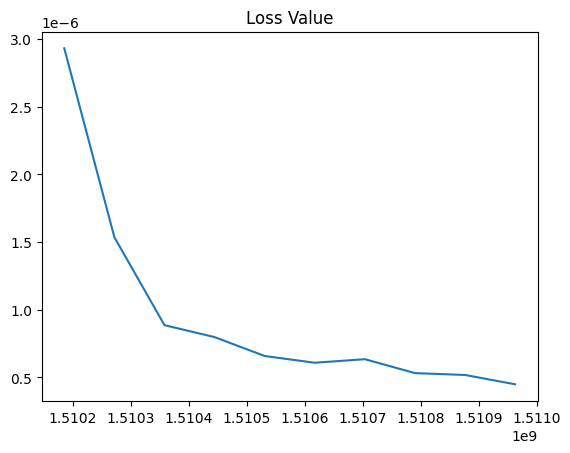

In [137]:
loss = history.history['loss']
plt.title("Loss Value")
plt.plot(file['Date'][:10], loss)

In [138]:
output = []
values = np.array(x_train[-12:])
values = values.reshape((1, 12))
for i in range(len(x_test)):
  prediction = model.predict(values)
  output.append(prediction)
  values = np.delete(values, 0)
  values = np.append(values, prediction)
  values = values.reshape((1, 12))

1/1 [==============================] - 0s 23ms/step


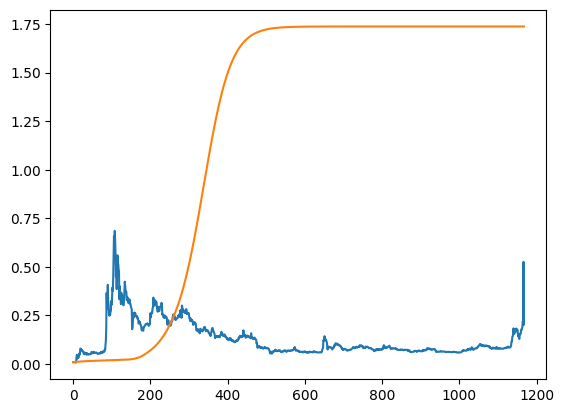

In [147]:
output = np.array(output)
output = output.reshape((1168))
plt.plot(x_test)
plt.plot(output)

In [144]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(x_test,output))
print(rmse)


1.3616671544742858
